## Create Initial states

In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import torch
import matplotlib.pyplot as plt
import copy 
import imageio


from src.models.normal import NormalDegradationModel as NModel
from src.models.particle_filter import ParticleFilterModel,ParticleFilterMLP
from src.models.system_rul import SystemRUL

from src.helpers.visualization import create_rul_prediciton_frame

## Task

In [2]:
data_name = "DS03"

device = "cpu"
pf_dir_name = 'pf_perform_relu64x64'


## Hyper-Parameters

In [3]:
# PF-net architecture
hidden_dims = [64,64]
activation = torch.nn.ReLU()

# PF parameters
n_particles = 2700
multiply_scale = 0.01

## Prediction settings
start_idx = 5
uncertainty_level = 0.95

## Plot resolution
t_grid = np.linspace(0.1, 100, 80) 
s_grid = np.linspace(0.0, 1.0, 60)

In [4]:
experiment_dir = Path('experiments')/data_name
pf_dir = experiment_dir/pf_dir_name
states_dir = experiment_dir/'states'

## Load pf-models

In [5]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')
dev_units = hi_df['unit'].astype(int).unique().tolist()
perform_names = [col for col in hi_df.columns if col not in ['unit','cycle','hs']]

del hi_df

dev_units 

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
pfs = {}
for name in perform_names:
	# load pf-network
	net = ParticleFilterMLP(state_dim=NModel.state_dim(), hidden_dims=hidden_dims,
                        activation=lambda : activation).to(device)
	ckpt = torch.load(pf_dir/name/'checkpoint.pt', map_location=device)
	net.load_state_dict(ckpt['model_state'])
	net = net.to(device).eval() 
	
	degmodels = []
	for unit in dev_units:
		best_model = NModel()
		best_model.load_state_dict(
			torch.load(states_dir/ name /f'unit_{unit}'/ "best_model.pt", map_location=device)
		)
		best_model.to(device)
		degmodels.append(best_model)
  
	perform_pf = ParticleFilterModel(base_models = degmodels,
									net = net,
									max_life=100,
									n_particles=n_particles,
									multiply_scale=multiply_scale,
									name=f'{name}_test').to(device)
	pfs[name] = perform_pf

## Create System RULs

In [7]:
sys_rul = SystemRUL(pf_models=pfs)

## Import test data


In [8]:
hi_df = pd.read_csv(experiment_dir/'hidata_test.csv')
del hi_df['hs']
test_units = hi_df['unit'].astype(int).unique().tolist()
test_units

[10, 11, 12, 13, 14, 15]

In [9]:
performs = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in test_units} 
    for name in perform_names
}
time = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in test_units}

## Prepare data

In [10]:
test_data = {}
for name, perform_units in performs.items():
    test_perform_data = {}
    for unit in test_units:
        t_data = time[unit]
        s_data = perform_units[unit]
        test_perform_data[unit]=torch.tensor(np.stack([t_data, s_data],axis=1),dtype=torch.float32).to(device)
    test_data[name]=test_perform_data

## System RUL

🎬 Video saved to experiments/DS03/pf_perform_relu64x64/rul_pred_test10.mp4


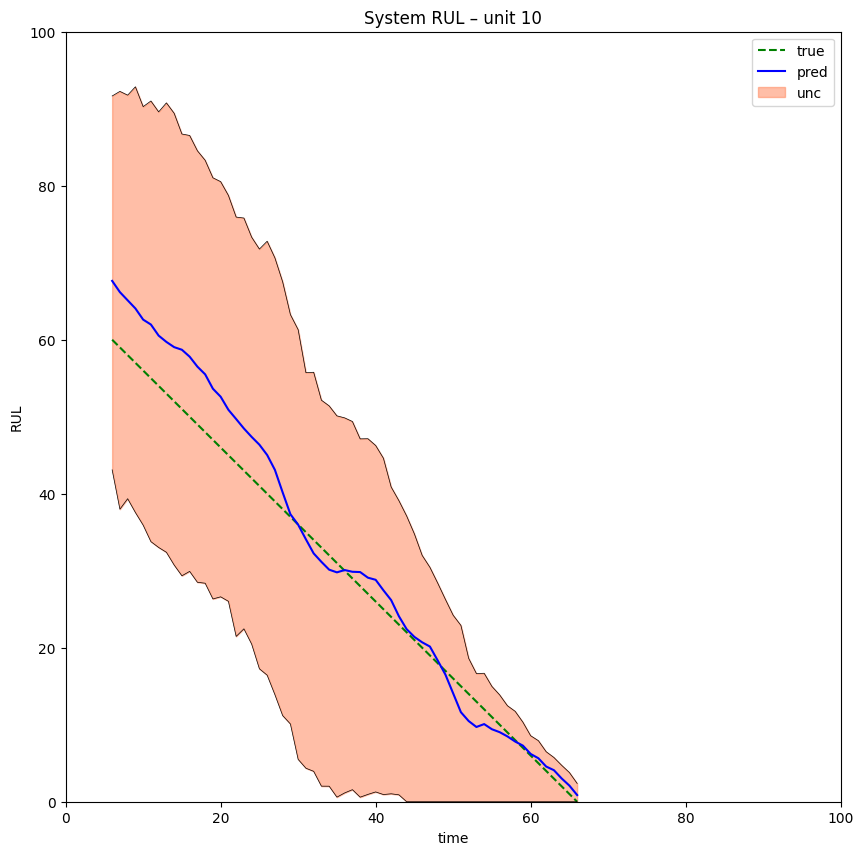

🎬 Video saved to experiments/DS03/pf_perform_relu64x64/rul_pred_test11.mp4


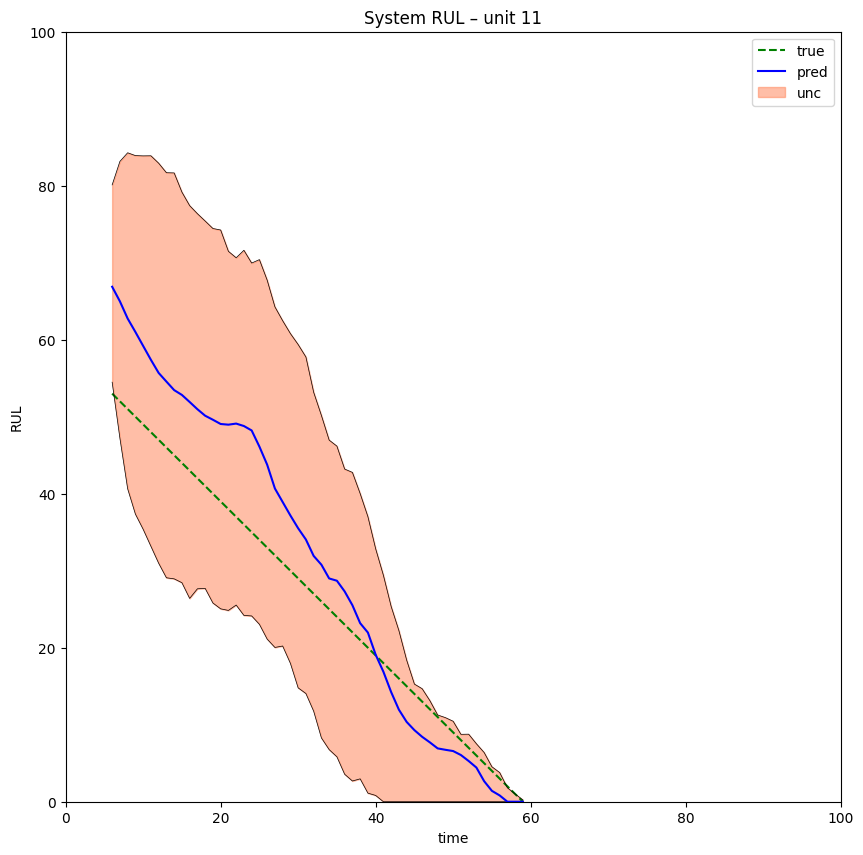

🎬 Video saved to experiments/DS03/pf_perform_relu64x64/rul_pred_test12.mp4


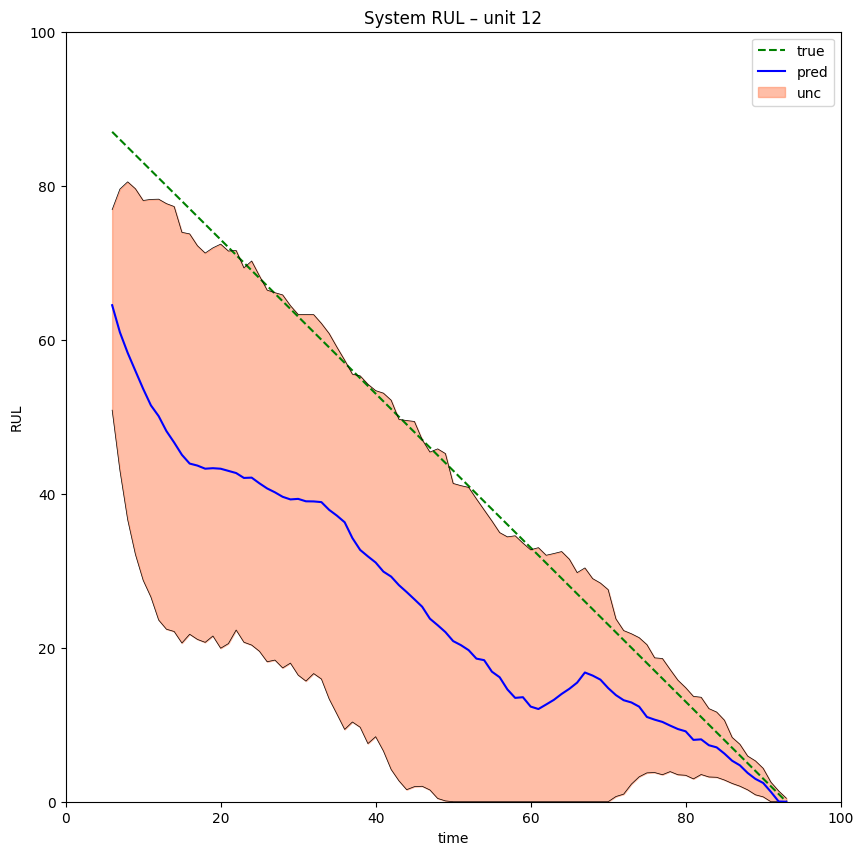

🎬 Video saved to experiments/DS03/pf_perform_relu64x64/rul_pred_test13.mp4


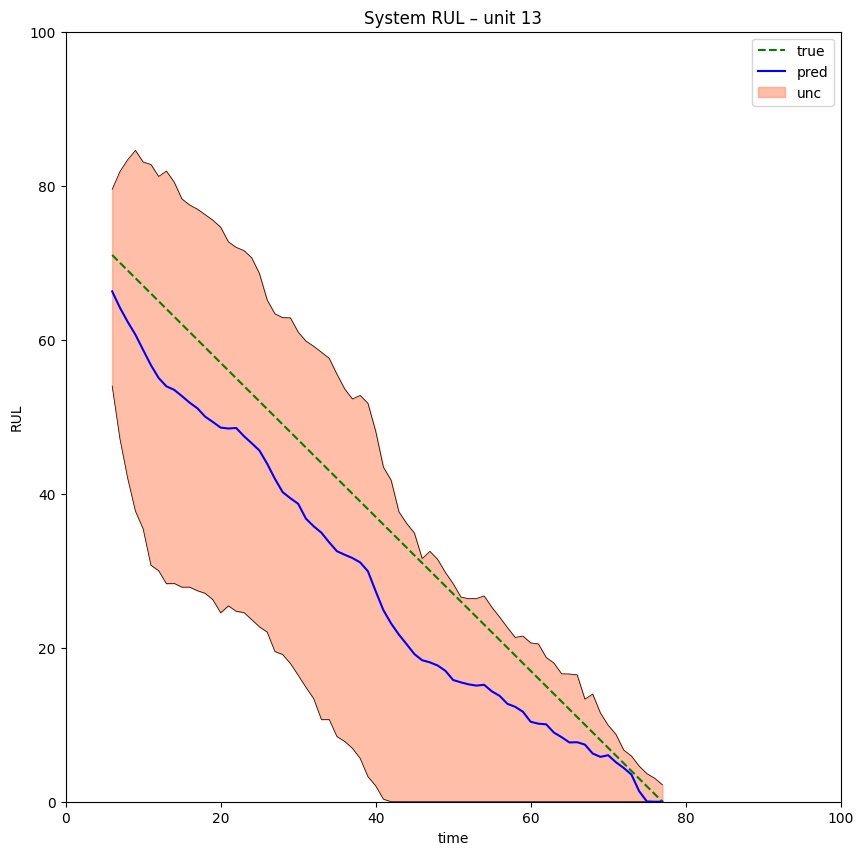

🎬 Video saved to experiments/DS03/pf_perform_relu64x64/rul_pred_test14.mp4


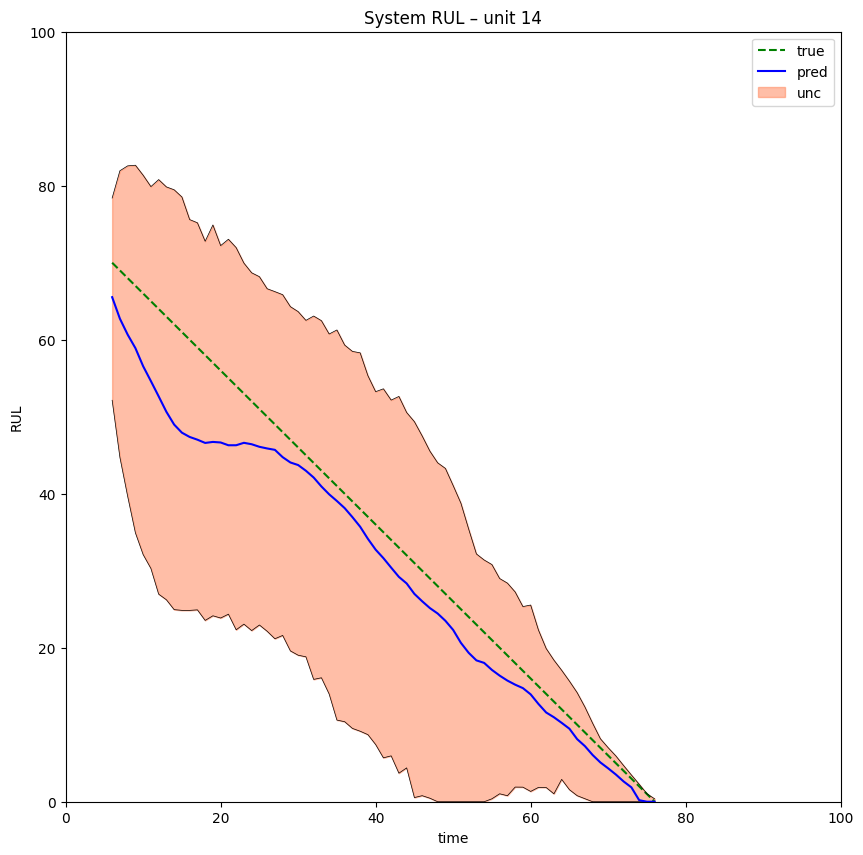

🎬 Video saved to experiments/DS03/pf_perform_relu64x64/rul_pred_test15.mp4


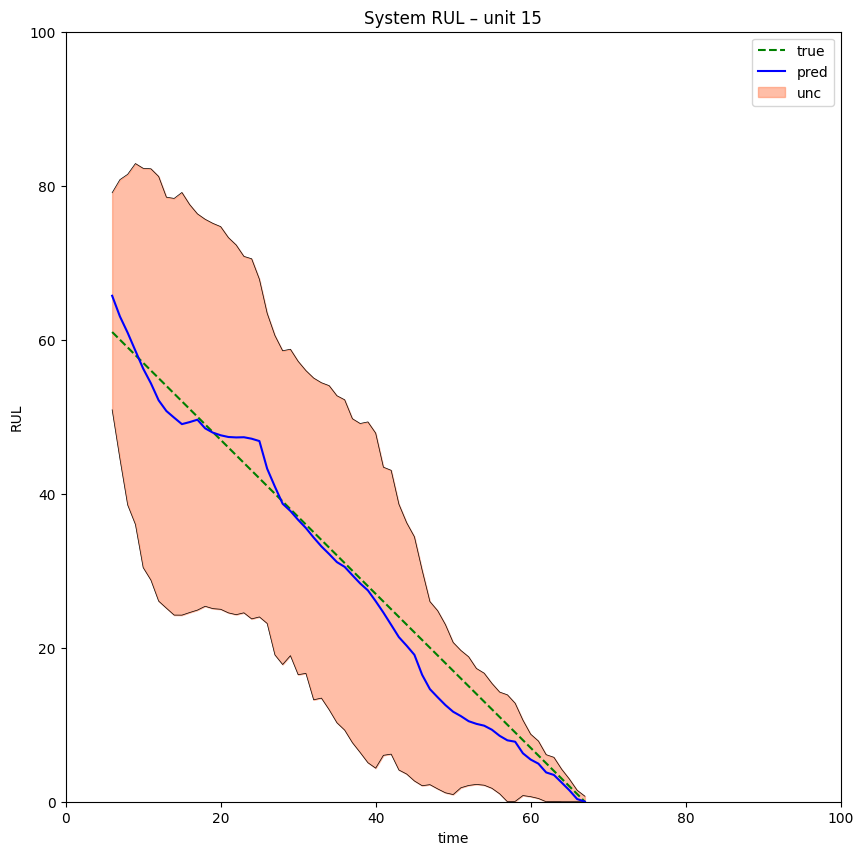

In [11]:
for test_unit in test_units:
	frames = []
	n_performs = len(sys_rul.pf_models)

	sys_rul.reset()

	data_s = {name: performs[name][test_unit] for name in perform_names}
	data_t = time[test_unit]
	for k, t_curr in enumerate(time[test_unit]):
		sys_rul.observe(
			time=t_curr,
			observations={name: s[k] for name,s in data_s.items()}
		)
		if k < start_idx:
			continue
		sys_rul.step()

		sys_rul.record(t_curr)

		frame = create_rul_prediciton_frame(
			sys_rul=sys_rul,
			step=k,
			t_grid=t_grid,
			s_grid=s_grid,
			t_data_np=data_t,
			s_data_np=data_s,
			uncertainty_level=uncertainty_level,
			eol_time=time[test_unit][-1],
			test_unit=test_unit,
			dist_vmax=0.3,
			dist_plot_mean=True,
			dist_legend_loc="lower left",
		)
	
		frames.append(frame)

	# Save video
	video_path = pf_dir/f'rul_pred_test{test_unit}.mp4'
	with imageio.get_writer(video_path, fps=8, macro_block_size=1) as writer:
		for frame in frames:
			writer.append_data(frame)

	print(f"🎬 Video saved to {video_path}")
 
	
	# Plot final RUL prediction
	fig, ax = plt.subplots(figsize=(10, 10))

	sys_rul.plot_rul(
		ax=ax,
		eol_time=time[test_unit][-1],
		y_max= 100,
		title=f"System RUL – unit {test_unit}",
	)
	plt.savefig(pf_dir/f'system_rul_test{test_unit}.png')
	plt.show()